In [1]:
import torch
import numpy as np
import pandas as pd
from torch import tensor
import matplotlib.pyplot as plt

In [2]:
wine_cols=['class',
'Alcohol',
'Malic acid',
'Ash',
'Alcalinity of ash'  ,
'Magnesium',
'Total phenols',
'Flavanoids',
'Nonflavanoid phenols',
'Proanthocyanins',
'Color intensity',
'Hue',
'OD280/OD315 of diluted wines',
'Proline']

wine=pd.read_csv('.../wine.data'
         ,header=None, names=wine_cols)

x,y=tensor(wine.iloc[:,1:].values),tensor(wine.iloc[:,0].values)

In [3]:
vals,indices=x.max(dim=0)

x_std = x/vals # normalising by max value

In [4]:
mean_vectors=[]

for i in torch.unique(y):

    mean_vectors.append(torch.mean(x_std[y==i],axis=0))

print(mean_vectors)

gen_mean=torch.mean(x_std,axis=0)

print(gen_mean)


[tensor([0.9268, 0.3467, 0.7602, 0.5679, 0.6564, 0.7320, 0.5871, 0.4394, 0.5305,
        0.4253, 0.6211, 0.7894, 0.6641], dtype=torch.float64), tensor([0.8280, 0.3332, 0.6950, 0.6746, 0.5836, 0.5822, 0.4096, 0.5510, 0.4554,
        0.2374, 0.6177, 0.6963, 0.3092], dtype=torch.float64), tensor([0.8870, 0.5748, 0.7545, 0.7139, 0.6130, 0.4327, 0.1538, 0.6780, 0.3222,
        0.5689, 0.3992, 0.4209, 0.3749], dtype=torch.float64)]
tensor([0.8766, 0.4028, 0.7327, 0.6498, 0.6157, 0.5915, 0.3995, 0.5483, 0.4444,
        0.3891, 0.5599, 0.6529, 0.4446], dtype=torch.float64)


In [5]:
cov_dict={}

between_class_list=[]

for i in torch.unique(y):

    n_i=x_std[y==i].shape[0]-1

    mean_err = x_std[y==i]-mean_vectors[i-1]

    cov_dict.update({ 'S_'+str(i): torch.matmul(mean_err.T,mean_err) / n_i })

    between_class_list.append(x_std.shape[0] * torch.matmul((mean_vectors[i-1]-gen_mean).reshape(1,-1).T,(mean_vectors[i-1]- gen_mean).reshape(1,-1)))

S_W=sum(cov_dict.values())    

S_B=sum(between_class_list)

print('Within-class scatter matrix shape:','\n',S_W.shape)

print('Between-class scatter matrix shape:','\n',S_B.shape)

Within-class scatter matrix shape: 
 torch.Size([13, 13])
Between-class scatter matrix shape: 
 torch.Size([13, 13])


In [6]:
eigen_vals, eigen_vecs= torch.linalg.eig(torch.matmul(torch.linalg.inv(S_W),S_B))

eigen_pairs = [(torch.abs(eigen_vals[i]), eigen_vecs[:,i])
                for i in range(len(eigen_vals))]

eigen_pairs = sorted(eigen_pairs,key=lambda k: k[0], reverse=True)

for i in eigen_pairs:

    print(i[0]) # Sorted eigenvalues

tensor(1865.0852, dtype=torch.float64)
tensor(682.9413, dtype=torch.float64)
tensor(2.3665e-13, dtype=torch.float64)
tensor(2.3665e-13, dtype=torch.float64)
tensor(1.6853e-13, dtype=torch.float64)
tensor(1.3799e-13, dtype=torch.float64)
tensor(1.1369e-13, dtype=torch.float64)
tensor(9.9799e-14, dtype=torch.float64)
tensor(8.3288e-14, dtype=torch.float64)
tensor(8.3288e-14, dtype=torch.float64)
tensor(4.7862e-14, dtype=torch.float64)
tensor(4.7862e-14, dtype=torch.float64)
tensor(3.8522e-16, dtype=torch.float64)


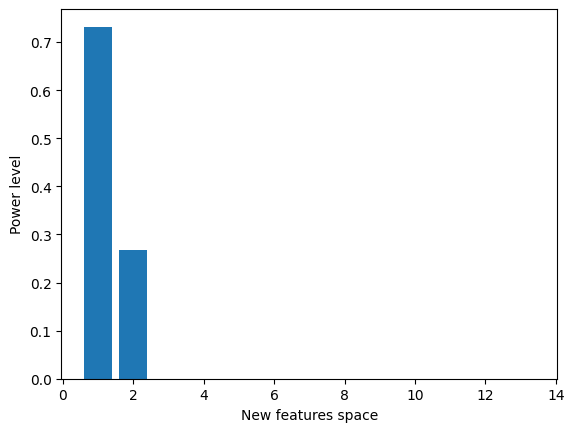

In [7]:
disc_power=[(i / eigen_vals.real.sum()) for i in sorted(eigen_vals.real, reverse=True)]

plt.bar(range(1,14),disc_power,alpha=1)

plt.xlabel('New features space')

plt.ylabel('Power level');

In [8]:
W=torch.stack((eigen_pairs[0][1].real,eigen_pairs[1][1].real),dim=1)

x_lda=torch.matmul(x_std,W)

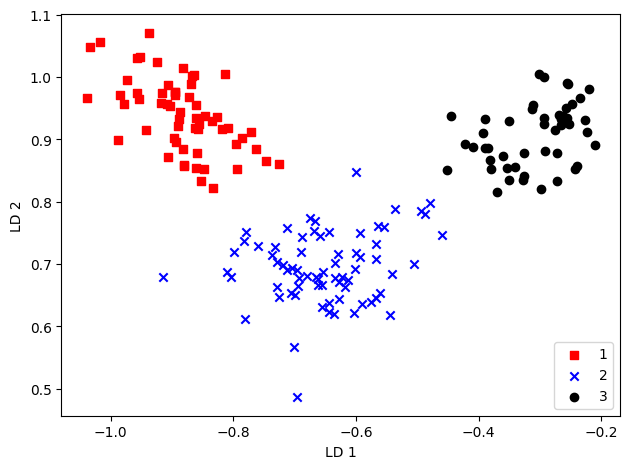

In [9]:
colors = ['r', 'b', 'black']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y), colors, markers):
     plt.scatter(x_lda[y==l, 0],
                 x_lda[y==l, 1] * (-1),
                 c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()

In [10]:
x_lda.shape[1]

2

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [12]:
x_train,x_test,y_train,y_test = train_test_split(x_lda, y, test_size=0.3, stratify=y)

In [13]:
lr=LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr=lr.fit(x_train, y_train)

In [14]:
y_pred=lr.predict(x_test)

In [15]:
print('Missclassification error: ',(np.array(y_test)!=y_pred).sum())

Missclassification error:  0
